In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-gaoliaoran2020")

In [ ]:
import geemap
import multiprocessing as mp
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
from google.colab import files

In [ ]:
area = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/WeiGan_Basin')

# 相关性/可分性评价

In [ ]:
baicheng = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/baicheng")
kuche = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/kuche")
shaya = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/shaya")
xinhe = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/xinhe")


# 选择样本
def renmoveProperty(feat):
  property = "Salinity"
  properties = feat.propertyNames()
  selectProperties = properties.filter(ee.Filter.eq('item', property))
  return feat.select(selectProperties)

def type_change(feature):
  pro = feature.get("Salinity")
  return feature.set("Salinity",ee.Number.parse(pro));

def sample0_2_add(feature):
    return feature.set("index",0);

def sample2_add(feature):
    return feature.set("index",1);

sample_point = ee.FeatureCollection(baicheng).merge(kuche).merge(shaya).merge(xinhe).filterBounds(area).map(type_change).map(renmoveProperty)
sample0_2 = sample_point.filter(ee.Filter.lt("Salinity",2)).filter(ee.Filter.gte("Salinity",0)).map(sample0_2_add)
sample2 = sample_point.filter(ee.Filter.gte("Salinity",2)).map(sample2_add)

In [ ]:
sample_point.filter(ee.Filter.lt("Salinity",3)).filter(ee.Filter.gte("Salinity",1))

## **各个指数有盐碱和无盐碱JM距离**

In [ ]:
def get_JM(image):
  point0_2 = image.sampleRegions(sample0_2, scale=10, tileScale=8)
  point2 = image.sampleRegions(sample2, scale=10, tileScale=8)
  LABEL = ee.FeatureCollection(point0_2).merge(point2)
  Data = LABEL
  imgData = image;
  bands = imgData.bandNames();
  def get_value(item):
    return ee.Feature(None).set('vec', item.toDictionary(bands).values(bands)).set('Class', item.get('index'))
  training = Data.map(get_value)
  lists = ee.List(training.reduceColumns(
    reducer = ee.Reducer.toList().group(0, 'class'),
    selectors = ['Class', 'vec']
    ).get('groups'));

  def creat_l_array(l):
    return ee.Array(l)

  def caculate_cov_mean(obj):
    array = ee.Array(ee.Dictionary(obj).get('list'))
    list = ee.List(ee.Dictionary(obj).get('list')).map(creat_l_array)
    mean = array.reduce(ee.Reducer.mean(), [0])
    covariance = list.reduce(ee.Reducer.covariance())
    return ee.Dictionary(obj).combine({
        "mean": mean.transpose(),
        "covariance": covariance
        })
  lists_New = lists.map(caculate_cov_mean)
  classes = ee.List.sequence(0, 1)

  def get_I(i):
    def get_J(j):
      mean_i = ee.Array(ee.Dictionary(lists_New.get(i)).get('mean'))
      mean_j = ee.Array(ee.Dictionary(lists_New.get(j)).get('mean'))
      sigma_i = ee.Array(ee.Dictionary(lists_New.get(i)).get('covariance'))
      sigma_j = ee.Array(ee.Dictionary(lists_New.get(j)).get('covariance'))
      mh = mean_i.subtract(mean_j).transpose() \
          .matrixMultiply(sigma_i.add(sigma_j).divide(2).matrixInverse()) \
          .matrixMultiply(mean_i.subtract(mean_j)) \
          .get([0, 0])
      t2 = sigma_i.add(sigma_j).divide(2).matrixDeterminant() \
          .divide(sigma_i.matrixDeterminant().sqrt()) \
          .divide(sigma_j.matrixDeterminant().sqrt()) \
          .log() \
          .divide(2)
      return mh.divide(8).add(t2)
    return classes.map(get_J)

  bhattacharyya = classes.map(get_I)

  jm = ee.Array(bhattacharyya).multiply(-1).exp() \
      .multiply(-1).add(1).multiply(2)
  return jm

#### **NDVI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def NDVI(image):
      Nir = image.select("B8");
      Red = image.select("B4");
      NDVI = Nir.subtract(Red).divide(Nir.add(Red));
      return image.select().addBands(NDVI)


    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(NDVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"NDVI")

jm = get_JM(Image)
jm

In [ ]:
NDVI_datacor = jm.getInfo()

#### **MSAVI**

In [ ]:
  # 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def MSAVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.multiply(2).add(1)).sqrt().divide(2).subtract((Nir.multiply(2).add(1).pow(2).subtract(Nir.subtract(Red).multiply(8))));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(MSAVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"MSAVI")

jm = get_JM(Image)
jm.getInfo()

[[-4.440892098500626e-16, 1.2479742203408188], [1.2479742203408188, 0]]

In [ ]:
MSAVI_datacor = jm.getInfo()

#### **RVI**

In [ ]:
# 构建原始波段时间序列
def RVI(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def RVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = Nir.subtract(Red).multiply(2.5).divide(Nir.add(Red.multiply(6)).subtract(Blue.multiply(7.5)).add(1))
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(RVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = RVI(start_time,end_time,day_gap,image_number,area,"RVI")

jm = get_JM(Image)
jm

In [ ]:
RVI_datacor = jm.getInfo()

#### **ARVI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def ARVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = Nir.subtract(Red.multiply(2).subtract(Blue)).divide(Nir.add(Red.multiply(2).subtract(Blue)))
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(ARVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"ARVI")

jm = get_JM(Image)
jm

In [ ]:
ARVI_datacor = jm.getInfo()

#### **SI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = Blue.multiply(Red).sqrt()
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SI")

jm = get_JM(Image)
jm

In [ ]:
SI_datacor = jm.getInfo()

#### **SI1**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SI1(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = Green.multiply(Red).sqrt()
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SI1).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SI1")

jm = get_JM(Image)
jm

In [ ]:
SI1_datacor = jm.getInfo()

#### **SI2**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SI2(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Green.pow(2).add(Red.pow(2)).add(Nir.pow(2))).sqrt()
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SI2).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SI2")

jm = get_JM(Image)
jm

In [ ]:
SI2_datacor = jm.getInfo()

#### **SI3**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SI3(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Green.pow(2).add(Red.pow(2))).sqrt()
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SI3).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SI3")

jm = get_JM(Image)
jm

In [ ]:
SI3_datacor = jm.getInfo()

#### **SAVI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SAVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      L = ee.Number(0.5)
      index = (Nir.subtract(Red)).multiply(L.add(1)).divide(Nir.add(Red).add(L));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SAVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SAVI")

jm = get_JM(Image)
jm

In [ ]:
SAVI_datacor = jm.getInfo()

#### **EVI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def EVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.subtract(Red)).multiply(2.5).divide(Nir.add(Red.multiply(6)).subtract(Blue.multiply(7.5)).add(1));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(EVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"EVI")

jm = get_JM(Image)
jm

In [ ]:
EVI_datacor = jm.getInfo()

#### **GDVI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def GDVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.pow(2).subtract(Red.pow(2))).divide(Nir.pow(2).add(Red.pow(2)));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(GDVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"GDVI")

jm = get_JM(Image)
jm

In [ ]:
GDVI_datacor = jm.getInfo()

#### **CRSI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def CRSI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = ((Nir.multiply(Red)).subtract(Green.multiply(Blue))).divide(((Nir.multiply(Red)).subtract(Green.multiply(Blue))).sqrt());
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(CRSI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"CRSI")

jm = get_JM(Image)
jm

In [ ]:
CRSI_datacor = jm.getInfo()

#### **SR**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SR(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = Nir.divide(Red);
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SR).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SR")

jm = get_JM(Image)
jm

In [ ]:
SR_datacor = jm.getInfo()

#### **EVI2**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def EVI2(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.subtract(Red)).multiply(2.5).divide(Nir.add(Red.multiply(2.4).add(1)));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(EVI2).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"EVI2")

jm = get_JM(Image)
jm

In [ ]:
EVI2_datacor = jm.getInfo()

#### **ENDVI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def ENDVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = (Nir.add(SWIR2).subtract(Red)).divide(Nir.add(SWIR2).add(Red));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(ENDVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"ENDVI")

jm = get_JM(Image)
jm

In [ ]:
ENDVI_datacor = jm.getInfo()

#### **EEVI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def EEVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      SWIR1 = image.select("B11").multiply(0.0001);
      index = (Nir.add(SWIR1).subtract(Red)).multiply(2.5).divide(Nir.add(SWIR1.add(Nir.multiply(6)).subtract(SWIR1.multiply(7.5)).multiply(Blue).multiply(2.5)).add(1));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(EEVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"EEVI")

jm = get_JM(Image)
jm

In [ ]:
EEVI_datacor = jm.getInfo()

#### **SIT**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SIT(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      SWIR1 = image.select("B11").multiply(0.0001);
      index = Red.divide(Nir).multiply(100);
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SIT).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SIT")

jm = get_JM(Image)
jm

In [ ]:
SIT_datacor = jm.getInfo()

#### **SIA**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SIA(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      SWIR1 = image.select("B11").multiply(0.0001);
      index = Blue.divide(Red);
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SIA).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SIA")

jm = get_JM(Image)
jm

In [ ]:
SIA_datacor = jm.getInfo()

#### **SIB**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SIB(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      SWIR1 = image.select("B11").multiply(0.0001);
      index = (Blue.subtract(Red)).divide(Blue.add(Red));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SIB).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SIB")

jm = get_JM(Image)
jm

In [ ]:
SIB_datacor = jm.getInfo()

#### **SAIO**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SAIO(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      SWIR1 = image.select("B11").multiply(0.0001);
      index = (Red.subtract(Nir)).divide(Green.add(Nir));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SAIO).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"SAIO")

jm = get_JM(Image)
jm

In [ ]:
SAIO_datacor = jm.getInfo()

#### **CLEX**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def CLEX(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      SWIR1 = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = SWIR1.divide(SWIR2);
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(CLEX).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"CLEX")

jm = get_JM(Image)
jm

In [ ]:
CLEX_datacor = jm.getInfo()

#### **GYEX**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def GYEX(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      SWIR1 = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = (SWIR1.subtract(Nir)).divide(SWIR1.add(Nir));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(GYEX).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"GYEX")

jm = get_JM(Image)
jm

In [ ]:
GYEX_datacor = jm.getInfo()

#### **BRI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def BRI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      SWIR1 = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = (Green.pow(2).add(Red.pow(2))).sqrt();
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(BRI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"BRI")

jm = get_JM(Image)
jm

In [ ]:
BRI_datacor = jm.getInfo()

#### **CAEX**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def CAEX(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      SWIR1 = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = Red.divide(Green);
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(CAEX).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"CAEX")

jm = get_JM(Image)
jm

In [ ]:
CAEX_datacor = jm.getInfo()

#### **FSEN**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def FSEN(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      SWIR1 = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = (SWIR1.subtract(SWIR2)).divide(SWIR1.add(SWIR2));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(FSEN).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"FSEN")

jm = get_JM(Image)
jm

In [ ]:
FSEN_datacor = jm.getInfo()

#### **NDII**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def NDII(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      SWIR1 = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = (Nir.subtract(SWIR1)).divide(Nir.add(SWIR1));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(NDII).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"NDII")

jm = get_JM(Image)
jm

In [ ]:
NDII_datacor = jm.getInfo()

#### **GVMI**

In [ ]:
# 构建原始波段时间序列
def Origin_band(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def GVMI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      SWIR1 = image.select("B2").multiply(0.0001);
      SWIR2 = image.select("B12").multiply(0.0001);
      index = (Nir.add(0.1).subtract(SWIR1.add(0.02))).divide(Nir.add(0.1).add(SWIR1.add(0.02)));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(GVMI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
Image = Origin_band(start_time,end_time,day_gap,image_number,area,"GVMI")

jm = get_JM(Image)
jm

In [ ]:
GVMI_datacor = jm.getInfo()

## **JM距离集合**

In [ ]:
data_dict = {"NDVI":NDVI_datacor[1][0],"MSAVI":MSAVI_datacor[1][0],"RVI":RVI_datacor[1][0],"ARVI":ARVI_datacor[1][0],"SI":SI_datacor[1][0],"SI1":SI1_datacor[1][0],"SI2":SI2_datacor[1][0],"SI3":SI3_datacor[1][0],"SAVI":SAVI_datacor[1][0],
    "EVI":EVI_datacor[1][0],"GDVI":GDVI_datacor[1][0],"CRSI":CRSI_datacor[1][0],"SR":SR_datacor[1][0],"EVI2":EVI2_datacor[1][0],"ENDVI":ENDVI_datacor[1][0],"EEVI":EEVI_datacor[1][0],"SIT":SIT_datacor[1][0],"SIA":SIA_datacor[1][0],
    "SIB":SIB_datacor[1][0],"SAIO":SAIO_datacor[1][0],"CLEX":CLEX_datacor[1][0],"GYEX":GYEX_datacor[1][0],"BRI":BRI_datacor[1][0],"CAEX":CAEX_datacor[1][0],"FSEN":FSEN_datacor[1][0],"NDII":NDII_datacor[1][0],"GVMI":GVMI_datacor[1][0]}
data = pd.DataFrame(data_dict, index=["JM Distance"])

In [ ]:
data

,NDVI,MSAVI,RVI,ARVI,SI,SI1,SI2,SI3,SAVI,EVI,...,SIA,SIB,SAIO,CLEX,GYEX,BRI,CAEX,FSEN,NDII,GVMI
JM Distance,1.147692,1.247974,1.206939,1.123905,1.206968,1.224718,1.083816,1.225944,1.160084,1.206939,...,0.9931,0.989544,1.137217,0.994996,1.045717,1.225944,1.041726,0.908233,1.045717,1.013089


In [ ]:
for i in data.columns.values.tolist():
  data[i] = round(data[i] , 3)

In [ ]:
list(data.index)

['JM Distance']

In [ ]:
data1 = data[["NDVI","MSAVI","RVI","ARVI","SI","SI1","SI2","SI3","SAVI"]]
data2 = data[["EVI","GDVI","CRSI","SR","EVI2","ENDVI","EEVI","SIT","SIA"]]
data3 = data[["SIB","SAIO","CLEX","GYEX","BRI","CAEX","FSEN","NDII","GVMI"]]

In [ ]:
data1

,NDVI,MSAVI,RVI,ARVI,SI,SI1,SI2,SI3,SAVI
JM Distance,1.148,1.248,1.207,1.124,1.207,1.225,1.084,1.226,1.16


In [ ]:
import matplotlib as mpl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

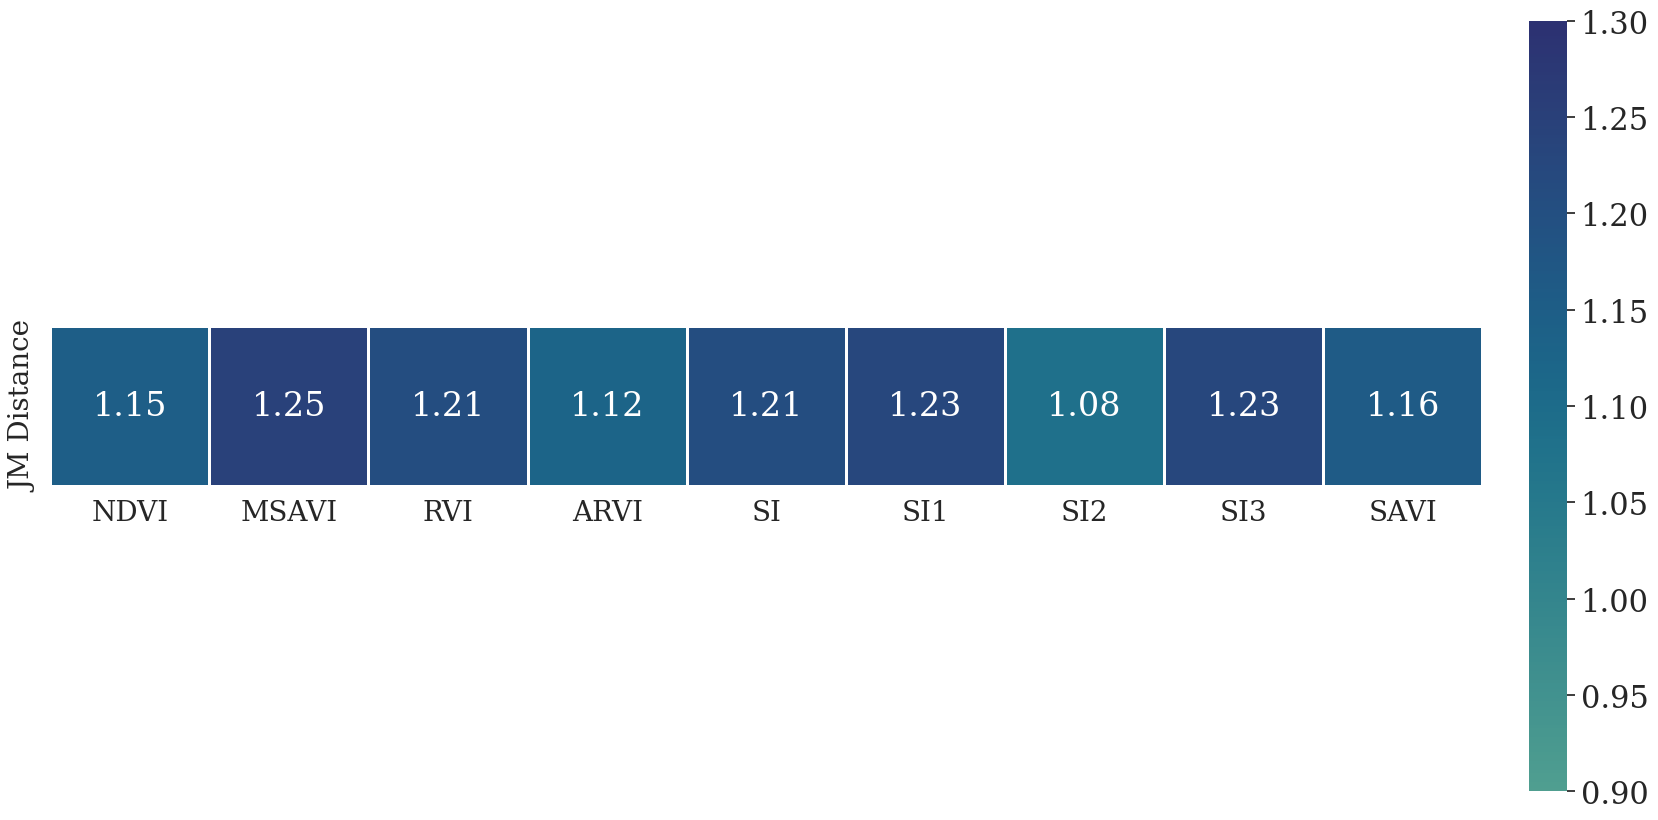

In [ ]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid",font_scale=2)
mpl.rc('font', family='serif')
ax=sns.heatmap(data1,vmin=0.9,vmax=1.3,square=True,annot=True,fmt=".2f",linewidths=2,cbar_kws={"fraction":0.046,"pad":0.03}, center=1.0, cmap="crest")
ylabs = list(data1.index)
xlabs = list(data1.columns)
ax.set_yticklabels(ylabs, fontsize=20)
ax.set_xticklabels(xlabs, fontsize=20)

# plt.show()
plt.savefig('7.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('7.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

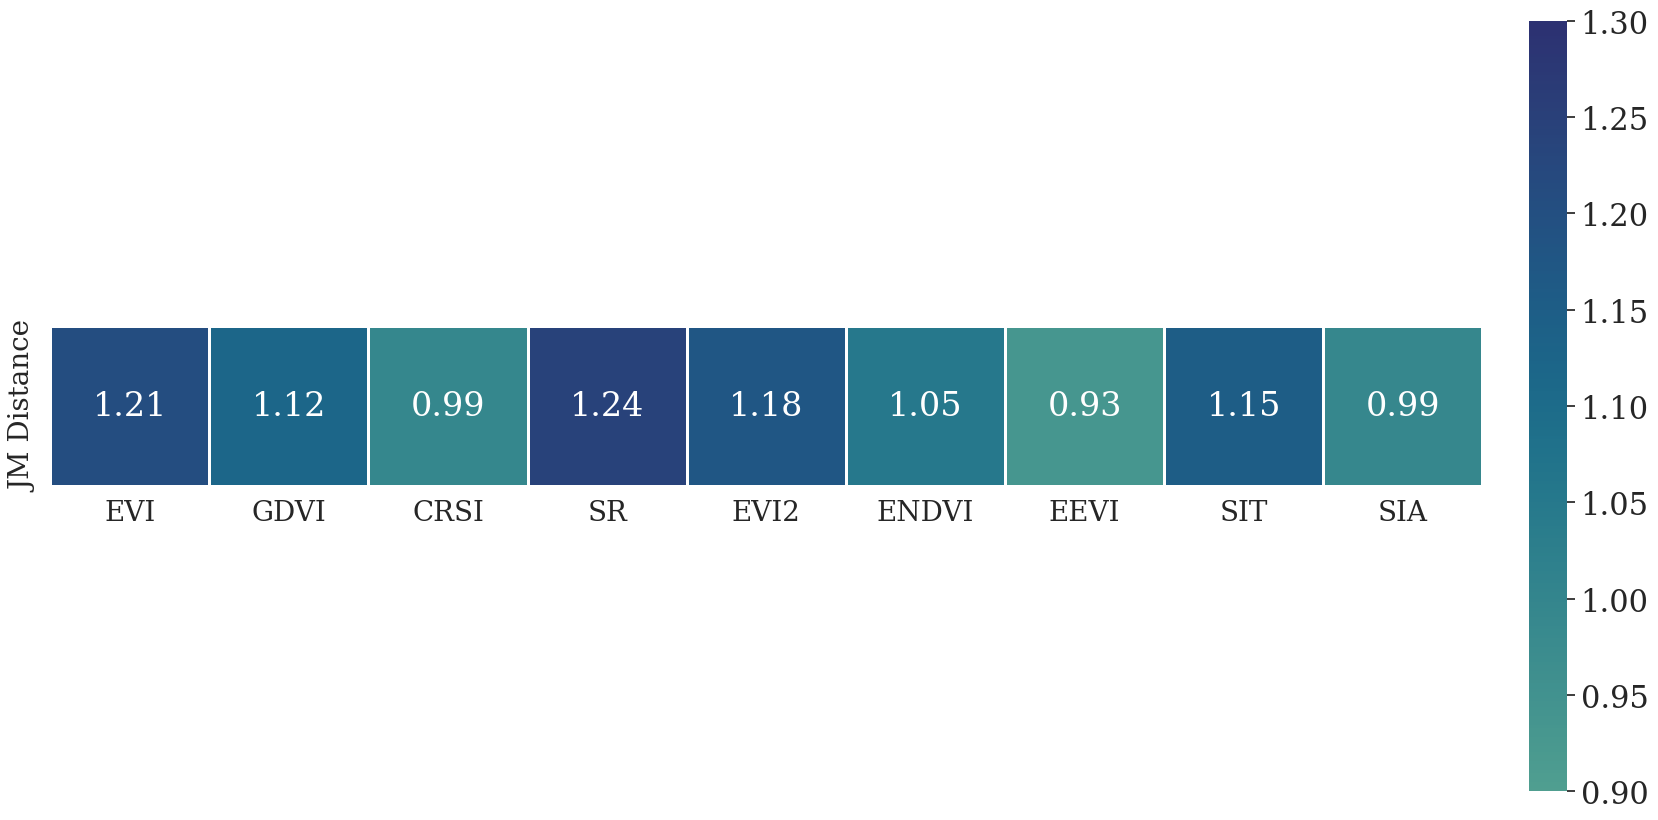

In [ ]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid",font_scale=2)
mpl.rc('font', family='serif')
ax=sns.heatmap(data2,vmin=0.9,vmax=1.3,square=True,annot=True,fmt=".2f",linewidths=2,cbar_kws={"fraction":0.046,"pad":0.03}, center=1.0, cmap="crest")
ylabs = list(data2.index)
xlabs = list(data2.columns)
ax.set_yticklabels(ylabs, fontsize=20)
ax.set_xticklabels(xlabs, fontsize=20)

# plt.show()
plt.savefig('7.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('7.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

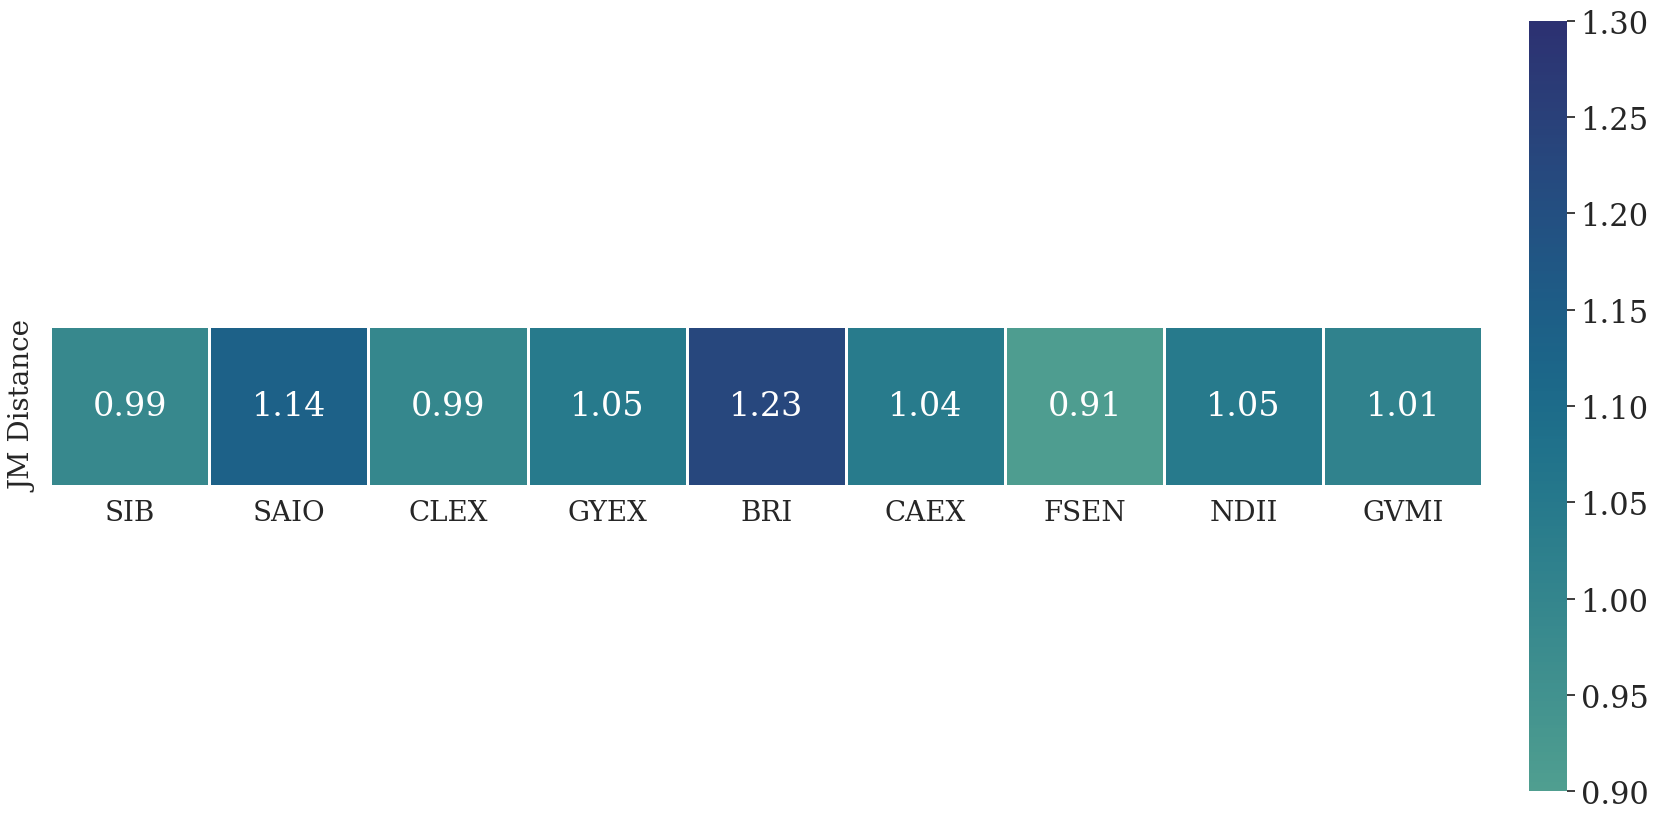

In [ ]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid",font_scale=2)
mpl.rc('font', family='serif')
ax=sns.heatmap(data3,vmin=0.9,vmax=1.3,square=True,annot=True,fmt=".2f",linewidths=2,cbar_kws={"fraction":0.046,"pad":0.03}, center=1.0, cmap="crest")
ylabs = list(data3.index)
xlabs = list(data3.columns)
ax.set_yticklabels(ylabs, fontsize=20)
ax.set_xticklabels(xlabs, fontsize=20)

# plt.show()
plt.savefig('7.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('7.tif')

## **组合特征JM可分性**

In [ ]:
# 构建原始波段时间序列
def MSAVI(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def MSAVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.multiply(2).add(1)).sqrt().divide(2).subtract((Nir.multiply(2).add(1).pow(2).subtract(Nir.subtract(Red).multiply(8))));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(MSAVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image


def SI1(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SI1(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = Green.multiply(Red).sqrt()
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SI1).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

def SI3(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SI3(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Green.pow(2).add(Red.pow(2))).sqrt()
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SI3).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image


def SR(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def SR(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = Nir.divide(Red);
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(SR).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image


def BRI(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def BRI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      SWIR1 = image.select("B11").multiply(0.0001);
      index = Red.divide(Nir).multiply(100);
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(BRI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image


# 设置时间序列开始和时间序列结束的时间点
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
MSAVIImage = MSAVI(start_time,end_time,day_gap,image_number,area,"MSAVI")
SI1Image = SI1(start_time,end_time,day_gap,image_number,area,"SI1")
SI3Image = SI3(start_time,end_time,day_gap,image_number,area,"SI3")
SRImage = SR(start_time,end_time,day_gap,image_number,area,"SR")
BRIImage = BRI(start_time,end_time,day_gap,image_number,area,"BRI")

Image = MSAVIImage.addBands(SI1Image).addBands(SI3Image).addBands(SRImage)#.addBands(BRIImage)
Image

In [ ]:
jm = get_JM(Image)
jm